# CNN Tutorial Classification
### Case: breast cancer (histopathology)

**Dataset**: [Kaggle-Breast Histopathology Images](https://www.kaggle.com/datasets/paultimothymooney/breast-histopathology-images)

**Summary**: The original dataset consisted of 162 whole mount slide images of Breast Cancer (BCa) specimens scanned at 40x. From that, 277,524 patches of size 50 x 50 were extracted (198,738 IDC negative and 78,786 IDC positive). Each patch’s file name is of the format: u_xX_yY_classC.png — > example 10253_idx5_x1351_y1101_class0.png . Where u is the patient ID (10253_idx5), X is the x-coordinate of where this patch was cropped from, Y is the y-coordinate of where this patch was cropped from, and C indicates the class where 0 is non-IDC and 1 is IDC. The original files are located here: http://gleason.case.edu/webdata/jpi-dl-tutorial/IDC_regular_ps50_idx5.zip

**Notes**: This notebook will only use 3 image folders out of the total 279 folders in the original dataset, and only use 1000 images for each class. Then for the model using CNN and transfer learning using ResNet101.

## Setup Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drives/')

Drive already mounted at /content/drives/; to attempt to forcibly remount, call drive.mount("/content/drives/", force_remount=True).


In [ ]:
import glob
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import cv2
import keras.utils as image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.applications import ResNet101

## Load Dataset

In [ ]:
breast_img = glob.glob("/content/drives/MyDrive/dataset/Histopathology_dataset/**/*.png",
                       recursive=True)

for imgname in breast_img[:3]:
  print(imgname)

/content/drives/MyDrive/dataset/Histopathology_dataset/8975/0/8975_idx5_x2901_y951_class0.png
/content/drives/MyDrive/dataset/Histopathology_dataset/8975/0/8975_idx5_x2151_y401_class0.png
/content/drives/MyDrive/dataset/Histopathology_dataset/8975/0/8975_idx5_x2401_y351_class0.png


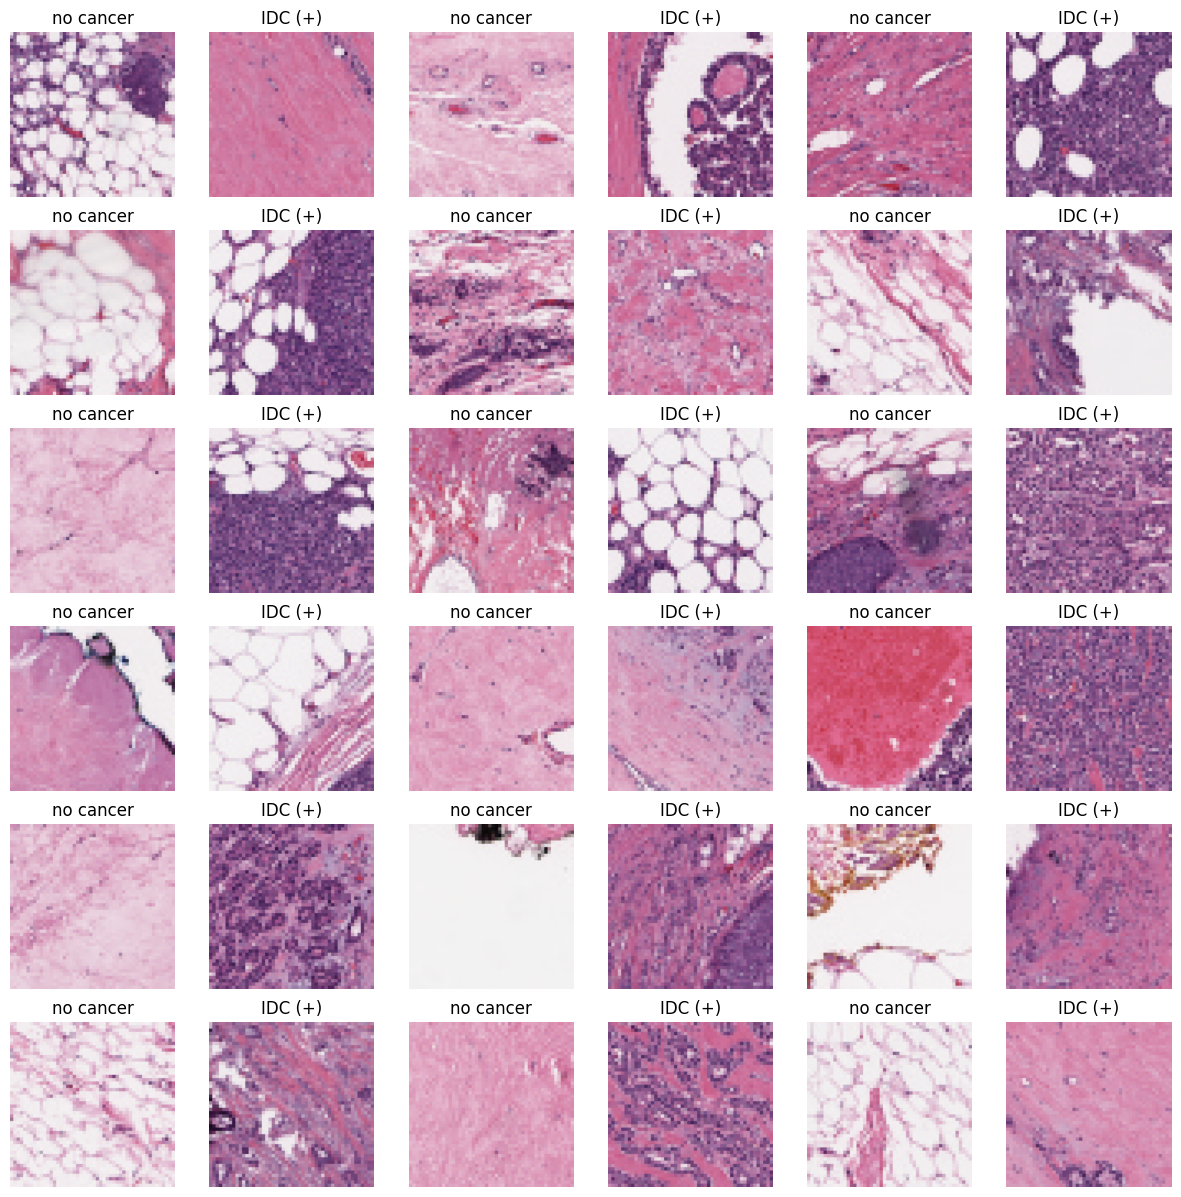

In [ ]:
N_IDC = []
P_IDC = []

for img in breast_img:
    if img[-5] == '0' :
        N_IDC.append(img)

    elif img[-5] == '1' :
        P_IDC.append(img)
plt.figure(figsize = (15, 15))

some_non = np.random.randint(0, len(N_IDC), 18)
some_can = np.random.randint(0, len(P_IDC), 18)

s = 0
for num in some_non:

        img = image.load_img((N_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s+1)
        plt.axis('off')
        plt.title('no cancer')
        plt.imshow(img.astype('uint8'))
        s += 1
s = 1
for num in some_can:

        img = image.load_img((P_IDC[num]), target_size=(100, 100))
        img = image.img_to_array(img)

        plt.subplot(6, 6, 2*s)
        plt.axis('off')
        plt.title('IDC (+)')
        plt.imshow(img.astype('uint8'))
        s += 1

In [ ]:
print(len(N_IDC)) # total of negative (non-cancer)
print(len(P_IDC)) # total positive (cancer)

# As an exercise, using 1000 images for each of + and -
newN_IDC = N_IDC[:1000]
newP_IDC = P_IDC[:1000]

print(f"using positive data totaling {len(newP_IDC)}")
print(f"using negative data totaling {len(newN_IDC)}")

2828
1198
using positive data totaling 1000
using negative data totaling 1000


## Pre-processing

In [ ]:
non_img_arr = []
can_img_arr = []

for img in newN_IDC:
  n_img = cv2.imread(img, cv2.IMREAD_COLOR)
  n_img_size = cv2.resize(n_img, (150, 150), interpolation = cv2.INTER_LINEAR)
  non_img_arr.append([n_img_size, 0])

for img in newP_IDC:
  c_img = cv2.imread(img, cv2.IMREAD_COLOR)
  c_img_size = cv2.resize(c_img, (150, 150), interpolation = cv2.INTER_LINEAR)
  can_img_arr.append([c_img_size, 1])

In [ ]:
print(len(non_img_arr))
print(len(can_img_arr))
print(len(non_img_arr)+len(can_img_arr)) # total dataset

1000
1000
2000


In [ ]:
X = []
y = []

# shuffle the combined data
breast_img_arr = non_img_arr + can_img_arr
random.shuffle(breast_img_arr)

for feature, label in breast_img_arr:
  X.append(feature)
  y.append(label)

X = np.array(X)
y = np.array(y)

In [ ]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X,y)

In [ ]:
print("Shape of X:", X.shape) # data gambar
print("Shape of y:", y.shape) # label (0, 1)

In [ ]:
# normalize data X
X = X / 255.0

In [ ]:
# Splitting dataset into 80:10:10
# Split data train (80%) and temp (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
# split temp for validation (10%) and test (10%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

In [ ]:
print("Training Data Shape:", X_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Testing Data Shape:", X_test.shape)

In [ ]:
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)
print("y_test shape:", y_test.shape)

### Save the pre-processed dataset

In [ ]:
# dump dataset to a pickle file
with open('dataset-full-histopathology.pkl', 'wb') as f:
    pickle.dump((X_train, X_val, X_test, y_train, y_val, y_test), f)

In [ ]:
# load dataset of pickle file
path_to_dataset = "/content/drives/MyDrive/dataset/final/dataset-full-histopathology.pkl"
with open(path_to_dataset, 'rb') as f:
    X_train, X_val, X_test, y_train, y_val, y_test = pickle.load(f)

To load pre-processed dataset:

In [ ]:
# check
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

### Add data augmentation

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest'
                                  )

train_generator = train_datagen.flow(X_train, y_train,
                                     batch_size=32)

val_datagen = ImageDataGenerator()

validation_generator = val_datagen.flow(X_val, y_val,
                                        batch_size=32)

## Train Model

In [ ]:
# utils
tf.keras.backend.clear_session()

### CNN Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax'),
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 20736)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │         663,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │              66 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 666,418 (2.54 MB)

 Trainable params: 666,418 (2.54 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 200ms/step - accuracy: 0.6346 - loss: 0.7367 - val_accuracy: 0.8850 - val_loss: 0.3384
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 9s 140ms/step - accuracy: 0.8521 - loss: 0.3838 - val_accuracy: 0.8000 - val_loss: 0.5474
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 196ms/step - accuracy: 0.8409 - loss: 0.3735 - val_accuracy: 0.9050 - val_loss: 0.2919
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 175ms/step - accuracy: 0.8760 - loss: 0.3341 - val_accuracy: 0.8700 - val_loss: 0.3842
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 141ms/step - accuracy: 0.8760 - loss: 0.3274 - val_accuracy: 0.8950 - val_loss: 0.2894
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 157ms/step - accuracy: 0.8732 - loss: 0.3273 - val_accuracy: 0.9000 - val_loss: 0.3011
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 10s 179ms/step - accuracy: 0.8724 - loss: 0.3260 - val_accuracy: 0.8900 - val_loss: 0.3008
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 139ms/step - accuracy: 0.8846 - loss: 0.3158 - val_accuracy: 0.9000 -

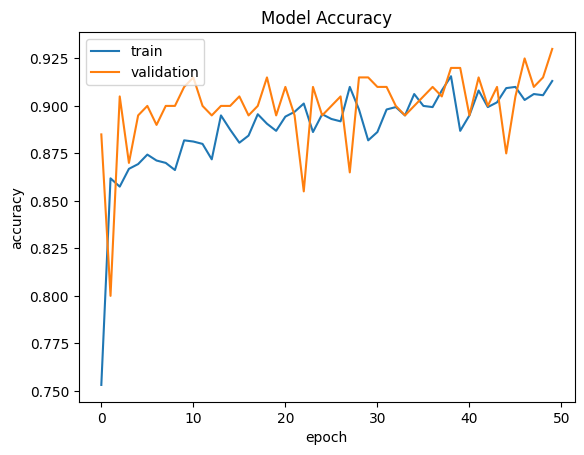

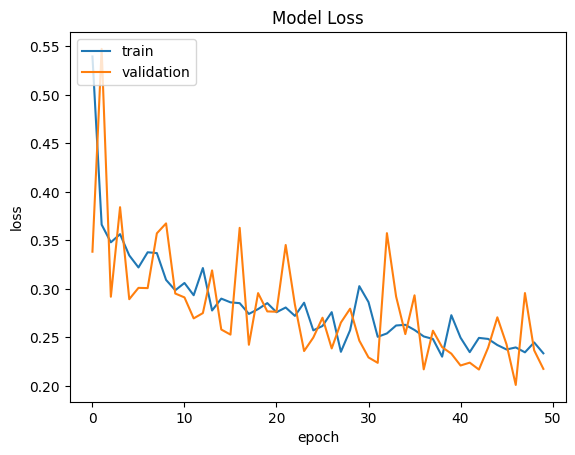

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

#### Evaluation

In [ ]:
model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - accuracy: 0.8735 - loss: 0.3078


[0.26550114154815674, 0.8999999761581421]

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Train Set Classification report:
               precision    recall  f1-score   support

   no cancer       0.94      0.89      0.91       791
     IDC (+)       0.90      0.94      0.92       809

    accuracy                           0.92      1600
   macro avg       0.92      0.92      0.92      1600
weighted avg       0.92      0.92      0.92      1600




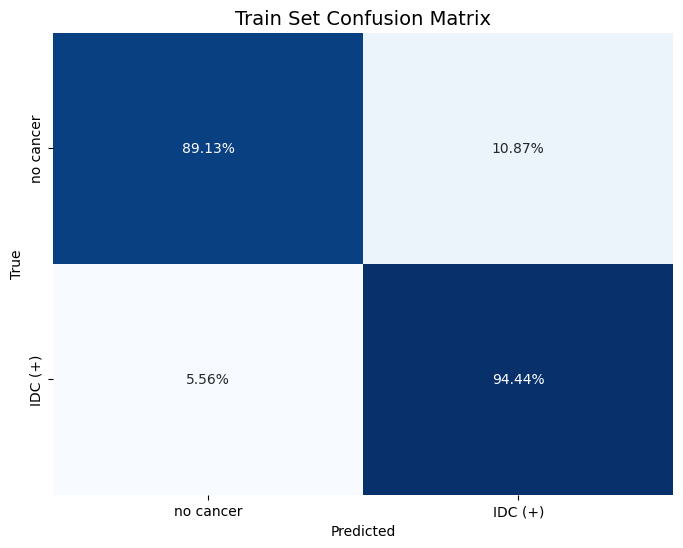

In [ ]:
# create labels for confusion matrix
cm_labels = ['no cancer', 'IDC (+)']

# obtain predictions
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# convert predicted probabilities to class predictions
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_train = np.argmax(y_pred_train, axis=1)

# Assuming y_test and y_val are in binary format (0 or 1)
y_true_classes_test = np.argmax(y_test, axis=1)
y_true_classes_train = np.argmax(y_train, axis=1)

# generate classification reports for test and val sets
test_report = classification_report(y_true_classes_test, y_pred_classes_test, target_names=cm_labels)
train_report = classification_report(y_true_classes_train, y_pred_classes_train, target_names=cm_labels)

# generate confusion matrices for test and validation sets
test_cm = confusion_matrix(y_true_classes_test, y_pred_classes_test)
train_cm = confusion_matrix(y_true_classes_train, y_pred_classes_train)

# create function to print confusion matrix
def plot_confusion_matrix(cm, labels, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# train score
print(f"Train Set Classification report:\n {train_report}\n")
plot_confusion_matrix(train_cm, cm_labels, 'Train Set Confusion Matrix')

Test Set Classification report:
               precision    recall  f1-score   support

   no cancer       0.94      0.87      0.90       107
     IDC (+)       0.86      0.94      0.90        93

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200




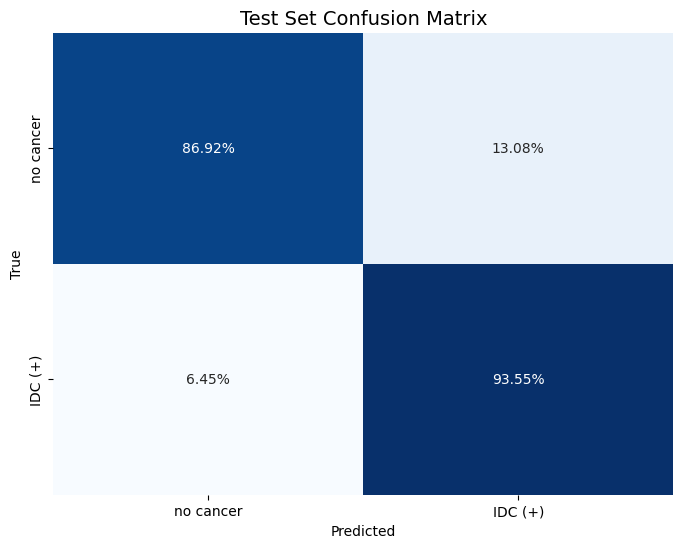

In [ ]:
# test score
print(f"Test Set Classification report:\n {test_report}\n")
plot_confusion_matrix(test_cm, cm_labels, 'Test Set Confusion Matrix')

### Transfer Learning ResNet101

In [ ]:
base_model = ResNet101(weights='imagenet',
                       include_top=False,
                       input_shape=(150, 150, 3))

In [ ]:
# unfreeze the last few layers in ResNet101
for layer in base_model.layers:
  layer.trainable = False
base_model.summary() # show full base_model architecture

Model: "resnet101"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 150, 150, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 156, 156, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 75, 75, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 75, 75, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 75, 75, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 77, 77, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 38, 38, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 38, 38, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 38, 38, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 38, 38, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 38, 38, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 38, 38, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 38, 38, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 42,658,176 (162.73 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 42,658,176 (162.73 MB)

In [ ]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_generator,
                    epochs=50,
                    validation_data=validation_generator)

Epoch 1/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 44s 408ms/step - accuracy: 0.5431 - loss: 0.9407 - val_accuracy: 0.6900 - val_loss: 0.6352
Epoch 2/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 215ms/step - accuracy: 0.6979 - loss: 0.6166 - val_accuracy: 0.7250 - val_loss: 0.5744
Epoch 3/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 221ms/step - accuracy: 0.7154 - loss: 0.5713 - val_accuracy: 0.7350 - val_loss: 0.5799
Epoch 4/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 184ms/step - accuracy: 0.7146 - loss: 0.5764 - val_accuracy: 0.7400 - val_loss: 0.5731
Epoch 5/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - accuracy: 0.7599 - loss: 0.5271 - val_accuracy: 0.7650 - val_loss: 0.5075
Epoch 6/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 226ms/step - accuracy: 0.7389 - loss: 0.5131 - val_accuracy: 0.7750 - val_loss: 0.5223
Epoch 7/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 12s 228ms/step - accuracy: 0.7395 - loss: 0.5328 - val_accuracy: 0.7850 - val_loss: 0.4763
Epoch 8/50
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - accuracy: 0.7599 - loss: 0.5212 - val_accu

#### Evaluation

In [ ]:
model.evaluate(X_test, y_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 17s 585ms/step - accuracy: 0.8402 - loss: 0.4194


[0.40240418910980225, 0.8450000286102295]

7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step
Train Set Classification report:
               precision    recall  f1-score   support

   MALIGNANT       0.86      0.79      0.83       791
      BENIGN       0.81      0.88      0.84       809

    accuracy                           0.84      1600
   macro avg       0.84      0.84      0.84      1600
weighted avg       0.84      0.84      0.84      1600




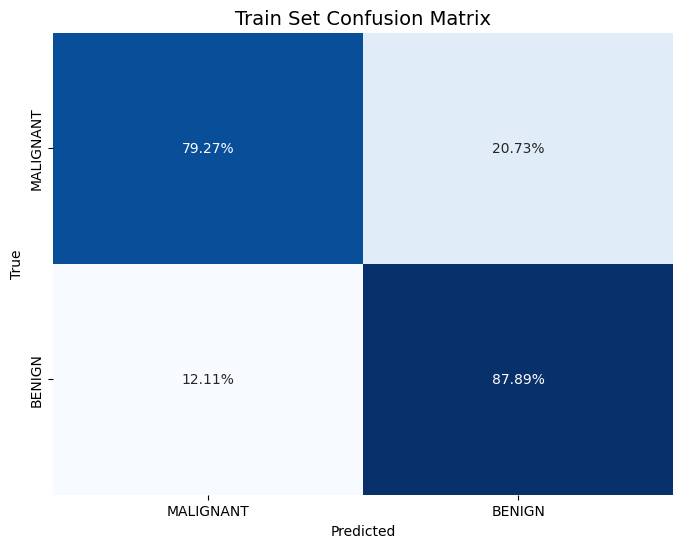

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# create labels for confusion matrix
cm_labels = ['MALIGNANT', 'BENIGN']

# obtain predictions
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# convert predicted probabilities to class predictions
y_pred_classes_test = np.argmax(y_pred_test, axis=1)
y_pred_classes_train = np.argmax(y_pred_train, axis=1)

# Assuming y_test and y_val are in binary format (0 or 1)
y_true_classes_test = np.argmax(y_test, axis=1)
y_true_classes_train = np.argmax(y_train, axis=1)

# generate classification reports for test and val sets
test_report = classification_report(y_true_classes_test, y_pred_classes_test, target_names=cm_labels)
train_report = classification_report(y_true_classes_train, y_pred_classes_train, target_names=cm_labels)

# generate confusion matrices for test and validation sets
test_cm = confusion_matrix(y_true_classes_test, y_pred_classes_test)
train_cm = confusion_matrix(y_true_classes_train, y_pred_classes_train)

# create function to print confusion matrix
def plot_confusion_matrix(cm, labels, title):
    """plots a normalized confusion matrix as a heatmap."""
    # Calculate row sums
    row_sums = cm.sum(axis=1, keepdims=True)
    # Normalize confusion matrix
    normalized_cm = cm / row_sums

    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cm, annot=True, fmt='.2%', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title, fontsize=14)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# print Train and Test reports and matrices
print(f"Train Set Classification report:\n {train_report}\n")
plot_confusion_matrix(train_cm, cm_labels, 'Train Set Confusion Matrix')

Test Set Classification report:
               precision    recall  f1-score   support

   MALIGNANT       0.91      0.79      0.84       107
      BENIGN       0.79      0.91      0.85        93

    accuracy                           0.84       200
   macro avg       0.85      0.85      0.84       200
weighted avg       0.85      0.84      0.84       200




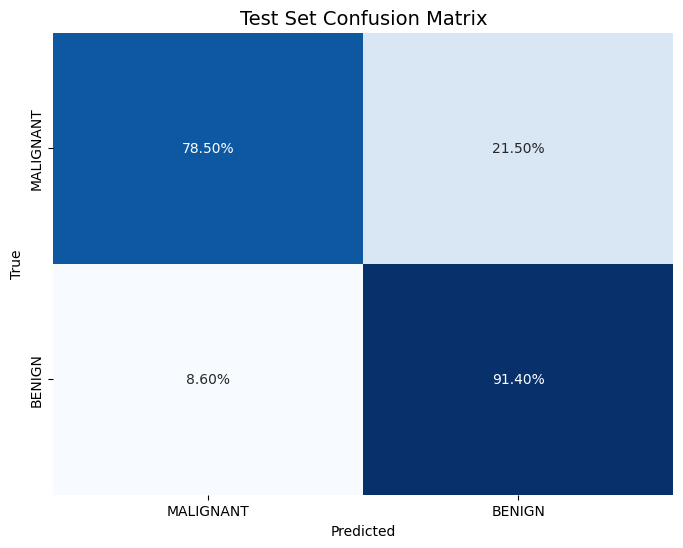

In [ ]:
# test score
print(f"Test Set Classification report:\n {test_report}\n")
plot_confusion_matrix(test_cm, cm_labels, 'Test Set Confusion Matrix')